# 2019 BRFSS Data Analysis Sample Project: Risk Factors and Demographic Predictors of Diabetes Diagnosis in U.S. Adults ≥ 18 years

## Pre-amble
- the preamble or beginning of our code
    - this is where we store everything that will be used later on
    - this includes modules and functions we will use in our code

In [204]:
import pandas as pd
import numpy as np
import pickle
import matplotlib 
from matplotlib import pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import statsmodels.api
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats

from sklearn import datasets, linear_model

In [205]:
#define a function to create cross tab bar plots in matplotlib
def crosstab_plots(var,titlexaxis): 
    """creates a cross tab bar plot with outcome variable diabetes diagnosis"""
    pd.crosstab(var,df_vis.DIABETE4).plot(kind="bar")
    plt.title(print('Diabetes Diagnosis by',titlexaxis))
    plt.xlabel(titlexaxis)
    plt.ylabel("Number Diagnosed with Diabetes")
    plt.savefig("plot")

## Data Import
- 2019 BRFSS data is public available on the CDC website at this link address:
- we will download the sas transport file available on the CDC website
    - this sas file is read very slowly into python so we will find an alternative import method  

In [206]:
# THIS CODE BLOCK IS OBSOLETE. USE PICKLED VERSION INSTEAD

# df = pd.read_sas('C:/Users/victo/Desktop/Coding_Practice/2019BRFSS.XPT') #read sas file
# Dump pandas df into pickle file because sas loading is so slow
# pickle.dump(df,open('data/2019BRFSS.p','wb'))

In [207]:
df = pickle.load(open('data/2019BRFSS.p','rb')) #reimport pickle file
print(df) #see below for output of printing our dataframe 

        _STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
0          1.0     1.0  b'01182019'  b'01'  b'18'  b'2019'    1100.0   
1          1.0     1.0  b'01132019'  b'01'  b'13'  b'2019'    1100.0   
2          1.0     1.0  b'01182019'  b'01'  b'18'  b'2019'    1100.0   
3          1.0     1.0  b'01182019'  b'01'  b'18'  b'2019'    1200.0   
4          1.0     1.0  b'01042019'  b'01'  b'04'  b'2019'    1100.0   
...        ...     ...          ...    ...    ...      ...       ...   
418263    72.0     9.0  b'03152020'  b'03'  b'15'  b'2020'    1100.0   
418264    72.0     9.0  b'03082020'  b'03'  b'08'  b'2020'    1100.0   
418265    72.0     9.0  b'03102020'  b'03'  b'10'  b'2020'    1100.0   
418266    72.0     9.0  b'03062020'  b'03'  b'06'  b'2020'    1100.0   
418267    72.0     9.0  b'03052020'  b'03'  b'05'  b'2020'    1100.0   

                SEQNO          _PSU  CTELENM1  ...  _VEGESU1  _FRTLT1A  \
0       b'2019000001'  2.019000e+09       1.0  ...     114.0 

In [208]:
df.info() #we can look at the file type, number of columns and rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418268 entries, 0 to 418267
Columns: 342 entries, _STATE to _AIDTST4
dtypes: float64(337), object(5)
memory usage: 1.1+ GB


## Research Question: What factors are predictive of having a diagnosis of diabetes nationally in men and non-pregnant women ≥18 years?

### Resources
- Full 2019 BRFSS questionnaire can be found at the following link: https://www.cdc.gov/brfss/questionnaires/pdf-ques/2019-BRFSS-Questionnaire-508.pdf
- Full 2019 BRFSS codebook can be found at the following link: https://www.cdc.gov/brfss/annual_data/2019/pdf/codebook19_llcp-v2-508.HTML
- Known Diabetes Risk factors : https://www.cdc.gov/diabetes/basics/risk-factors.html     

In [209]:
#A way to inspect only the number of rows and columns in our dataframe
df.shape 

(418268, 342)

### Define our population: non-pregnant U.S. adults (18 years or older) 
#### Subset our data by removing anyone under 18 years and anyone who is currently pregnant (pregnancy makes BMI tricky to analyze so we will simplify things for ourselves by simply removing pregnant individuals from the dataset)
- Variables we will use: 
    - "18 years of age or older?": LADULT1 1-Yes, 2-No 
    - "Currently pregnant?" PREGNANT 1-Yes, 2-No, 7-Don't know/ Not sure, 9-Refused

In [210]:
#Check frequency for PREGNANT variable
df['PREGNANT'].value_counts() 

2.0    70617
1.0     2122
9.0      201
7.0      181
Name: PREGNANT, dtype: int64

In [211]:
#Check frequency for LADULT1 variable
df['LADULT1'].value_counts(dropna=False) #specify not to drop the na or missing values  
#see output - most people leave the question blank
    #if the question is answered no then respondents must stop taking the survey 
    #149,941 respondents say they're adults
        #option 1: Keep all the data since you must be 18 years or older as a requirement to take the BRFSS
        #option 2: subset by continuous variable AGE

NaN    268327
1.0    149941
Name: LADULT1, dtype: int64

In [212]:
#Let's take a look at option 2
    #it appears the variable AGE is not included in the dataset 
if "AGE" in df.columns:
    print("True")
else:
    print("False")

False


In [213]:
#The CDC only gives us BRFSS data with age in age categories 
    #view codebook for more info 
if "_AGE_G" in df.columns:
    print("True")
else:
    print("False")
    #thus we will go with option 1 and keep all the data, assuming everyone who took the survey is an adult

True


In [214]:
#subset the data
     #include all response of PREGNANT not equal to 1
df_pop = df[df.PREGNANT != 1]

#check frequency of PREGNANT in new df_pop
df_pop["PREGNANT"].value_counts(dropna=False)

NaN    345147
2.0     70617
9.0       201
7.0       181
Name: PREGNANT, dtype: int64

In [215]:
#check out dataframe to see it has shrunk by the num of pregnant individuals
df_pop.shape

(416146, 342)

### Create a binary outcome variable: Diabetes Diagnosis (not including gestational)
#### Diabetes diagnosis is our outcome variable and we would like to have yes/ no categories 
- Question: "Ever been told you have diabetes?" 
    - Variable name: DIABETE4
    - Values: 1-Yes, 2-Gestational only, 3-No, 4-Prediabetes or borderline diabetes, 7-Don't know, 9-Refused

In [216]:
df_pop["DIABETE4"].value_counts(dropna=False)

3.0    345123
1.0     57362
4.0      9131
2.0      3689
7.0       601
9.0       231
NaN         9
Name: DIABETE4, dtype: int64

In [217]:
#remove don't know and refused values
df_outcome=df_pop[(df_pop["DIABETE4"]!=7) & (df_pop["DIABETE4"]!=9)]
#remove missing values 
    #dropna(inplace=True) can also be used instead of assigning df_outcome to df_outcome
df_outcome=df_outcome.dropna(subset=["DIABETE4"])
#check frequency of DIABETE4
df_outcome['DIABETE4'].value_counts(dropna=False)


3.0    345123
1.0     57362
4.0      9131
2.0      3689
Name: DIABETE4, dtype: int64

In [218]:
df_outcome.shape

(415305, 342)

In [219]:
#assign values 2 and 3 to 0 
#assign values 4 to 1 - include prediabetes and borderline diabetes with diabetes diagnosis
df_outcome["DIABETE4"].replace({1:1,2:0,3:0,4:1},inplace=True)

#check frequency 
df_outcome["DIABETE4"].value_counts(dropna=False)
#great, now we have a binary outcome variable where 1- no diabetes and 2-diabetes/ prediabetes/ borderline diabetes

0.0    348812
1.0     66493
Name: DIABETE4, dtype: int64

### Data Exploration through Data Visualizations
#### We are interested in exploring known risk factors as well as social determinants of health
#### We can determine what are good predictors of diabetes diagnosis by using matplotlib to look visually. We will use the function defined in our preamble to do this.
##### BMI can be a good predictor of diabetes diagnosis - as BMI class increases so does the number of diabetes diagnoses

Diabetes Diagnosis by BMI Class


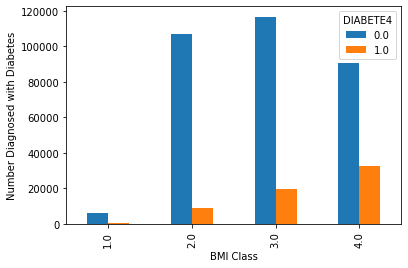

In [220]:
df_vis=df_outcome 
#_BMI5CAT 1-Underweight, 2-Normal weight, 3-Overweight, 4-Obese 
crosstab_plots(df_vis._BMI5CAT,"BMI Class")


##### Exercise can be a good predictor of diabetes diagnosis - higher proportion of diabetes diagnoses for those who do not exercise

Diabetes Diagnosis by Exercise


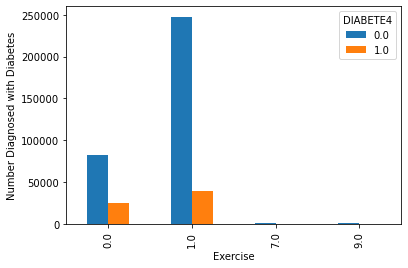

In [221]:
#EXERANY2 1-Yes, 2-No
#recode as 1-No, 2-Yes
df_vis["EXERANY2"].replace({1:1,2:0},inplace=True)
crosstab_plots(df_vis.EXERANY2,"Exercise")

##### There does not seem to be a lower proportion of diabetes diagnoses among white respondents than respondents who identify as other races, but the relationship is not clear for other racial categories - given more time, this would be interesting to explore but we won't include it in our model today

Diabetes Diagnosis by Race/ Ethnicity


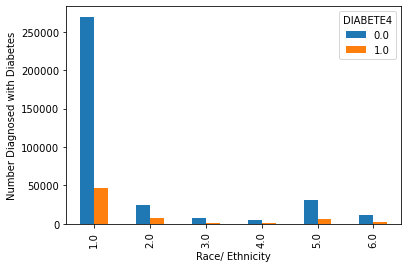

In [222]:
#_IMPRACE 1-White, 2-Black, 3-Asian, 4-American Indian/ Alaska Native, 5-Hispanic, 6-Other race
crosstab_plots(df_vis._IMPRACE,"Race/ Ethnicity")

##### Education level can be a good predictor of diabetes diagnosis - college grads have a lot lower proportion of diabetes than do those with a lower educational attainment level

Diabetes Diagnosis by Education Level


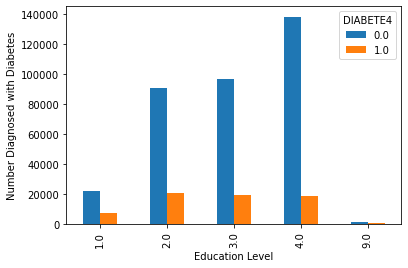

In [223]:
#_EDUCAG 1-not graduated HS, 2-Graduated HS, 3-Attended college or technical school
#4-Graduated from college or techincal school
crosstab_plots(df_vis._EDUCAG,"Education Level")

##### Sex at birth can be a good predictor of diabetes diagnosis - higher proportion of diabetes diagnoses among men than women

Diabetes Diagnosis by Sex at Birth


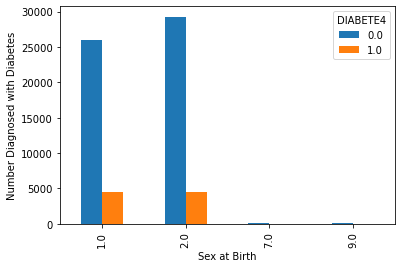

In [224]:
#BIRTHSEX 1-Male, 2-Female
crosstab_plots(df_vis.BIRTHSEX,"Sex at Birth")
#Recode 0-Female, 1-Male
df_vis["BIRTHSEX"].replace({1:1,2:0},inplace=True)

##### Health plan is not a good predictor of diabetes diagnosis

Diabetes Diagnosis by Insured vs Uninsured


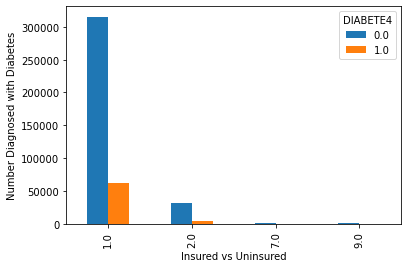

In [225]:
#HLTHPLN1 1-Yes, 2-No
crosstab_plots(df_vis.HLTHPLN1,"Insured vs Uninsured")

##### We include food stamps as an indicator of income since one has to make below a certain income to qualify 
##### Whether someone has food stamps or not can be a good predictor of diabetes diagnosis - those who have food stamps have a higher proportion of diabetes diagnoses

Diabetes Diagnosis by Food Stamp Category


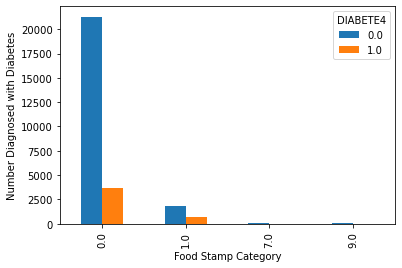

In [226]:
#FOODSTMP 1-Yes, 2-No
#recode 0-No, 1-Yes
df_vis["FOODSTMP"].replace({1:1,2:0},inplace=True)
crosstab_plots(df_vis.FOODSTMP,"Food Stamp Category")

##### Cholesterol can be a good predictor of diabetes diagnosis - those who have high cholesterol also have a higher proportion of diabetes diagnoses

Diabetes Diagnosis by Ever had High Cholesterol


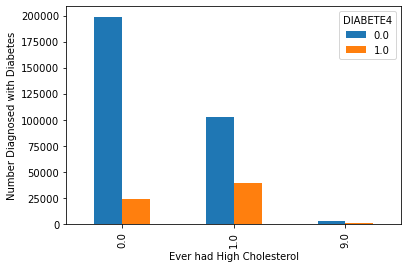

In [227]:
#_RFCHOL2 1-No, 2-Yes
#recode 0-No, 1-Yes
df_vis["_RFCHOL2"].replace({1:0,2:1},inplace=True)
crosstab_plots(df_vis._RFCHOL2,"Ever had High Cholesterol")

### Predictor Variables - Data Clean-up

#### We're going to use the following variables in our model: _BMI5, EXERANY2, _EDUCAG, BIRTHSEX, FOODSTMP, _RFCHOL2 
- Let's remove the 7- Don't Know and 9-Refused for these variables wherever applicable

In [228]:
#we could def a function since we're reiterating this step several times
    #but this is only one line of code anyways so creating a function doesn't save us much time 

#_BMI5 is continuous so not applicable
#Remove 7 and 9 responses for EXERANY2
df_vis=df_vis[(df_vis["EXERANY2"]!=7) & (df_vis["EXERANY2"]!=9)]
df_vis=df_vis[(df_vis["BIRTHSEX"]!=7) & (df_vis["BIRTHSEX"]!=9)]
df_vis=df_vis[(df_vis["FOODSTMP"]!=7) & (df_vis["FOODSTMP"]!=9)]
df_vis=df_vis[(df_vis["BPMEDS"]!=7) & (df_vis["BPMEDS"]!=9)]

#_EDUCAG AND _RFCHOL2 only have 9 response to remove
df_vis=df_vis[df_vis["_EDUCAG"]!=9]
df_vis=df_vis[df_vis["_RFCHOL2"]!=9]

df_vis.shape #we reduced num of rows but column num stayed the same 

#we can also check to see if this worked by running this cell first and then re-running the above crosstab plots
    #doing so, we would expect to no longer see the values 7 and 9 for the variables we selected to include in our model

(408617, 342)

### Handle missing values before logistic regression
#### We have a few options - we can remove all missing values but if we want to keep most of the data it is not a good option; there exist additional data imputation methods for dealing with missing values before running a regression analyses

In [229]:
#Let's first try taking out all of the rows with missing values for our predictors
df_nona=df_vis.dropna(subset=["_BMI5","EXERANY2","_EDUCAG","BIRTHSEX","FOODSTMP","_RFCHOL2"])
df_nona.shape #inspect new row num

(13788, 342)

#### We still have a more than large enough sample size to run regression analyses without the drawbacks of data imputation

### Create Dummy Variables 
#### For predictor variables with more than 2 categories
##### Only educational level has more than 2 categories

In [230]:
#create dummy variable from _EDUCAG
dummy=pd.get_dummies(df_nona["_EDUCAG"])
#we will name the columns of the new dummy variable
dummy=dummy.rename(columns={1.0: "EDUC_HSnograd", 2.0: "EDUC_HSgrad", 3.0:"EDUC_Colattend",4.0:"EDUC_Colgrad"})
#view 
dummy.head()

,EDUC_HSnograd,EDUC_HSgrad,EDUC_Colattend,EDUC_Colgrad
142006,0,0,1,0
142008,0,0,0,1
142009,0,0,1,0
142010,0,0,1,0
142011,0,0,1,0


In [231]:
#add our dummy variable as columns to our existing data
df_dum=pd.concat([df_nona,dummy],axis=1)
df_dum.head()

#view the first few rows to see if our dummy variables were added correctly 
print(df_dum.loc[:,["_EDUCAG","EDUC_HSnograd","EDUC_HSgrad","EDUC_Colattend",'EDUC_Colgrad']].head())

        _EDUCAG  EDUC_HSnograd  EDUC_HSgrad  EDUC_Colattend  EDUC_Colgrad
142006      3.0              0            0               1             0
142008      4.0              0            0               0             1
142009      3.0              0            0               1             0
142010      3.0              0            0               1             0
142011      3.0              0            0               1             0


### Logisitic Regression
#### Colinearity Statistics - Test for independence among predictor variables using VIF
- we are looking for VIF about equal to or less than 5

In [232]:
# VIF dataframe
X_VIF= df_dum[["_BMI5","EXERANY2","BIRTHSEX","FOODSTMP","_RFCHOL2","_EDUCAG"]]
vif_data = pd.DataFrame()
vif_data["feature"] = X_VIF.columns
  
# calculating VIF for each
vif_data["VIF"] = [variance_inflation_factor(X_VIF.values, i)
                          for i in range(len(X_VIF.columns))]
print(vif_data)

    feature       VIF
0     _BMI5  9.437700
1  EXERANY2  4.580095
2  BIRTHSEX  1.932979
3  FOODSTMP  1.111818
4  _RFCHOL2  1.599334
5   _EDUCAG  9.696033


#### There seems to be some correlation between BMI and education
##### Drop education from the final model and inspect VIF 

In [233]:
X_VIF.corr()

,_BMI5,EXERANY2,BIRTHSEX,FOODSTMP,_RFCHOL2,_EDUCAG
_BMI5,1.000000,-0.139655,0.048452,0.083705,0.113184,-0.085640
EXERANY2,-0.139655,1.000000,0.017207,-0.110689,-0.061251,0.210735
BIRTHSEX,0.048452,0.017207,1.000000,-0.074753,0.042604,-0.029309
FOODSTMP,0.083705,-0.110689,-0.074753,1.000000,0.026923,-0.211102
_RFCHOL2,0.113184,-0.061251,0.042604,0.026923,1.000000,-0.046683
_EDUCAG,-0.085640,0.210735,-0.029309,-0.211102,-0.046683,1.000000


#### Dropping education allows for more independence among predictor variables

In [234]:
# VIF dataframe
X_VIF= df_dum[["_BMI5","EXERANY2","BIRTHSEX","FOODSTMP","_RFCHOL2"]]
vif_data = pd.DataFrame()
vif_data["feature"] = X_VIF.columns
  
# calculating VIF for each
vif_data["VIF"] = [variance_inflation_factor(X_VIF.values, i)
                          for i in range(len(X_VIF.columns))]
print(vif_data)

    feature       VIF
0     _BMI5  5.046511
1  EXERANY2  3.700714
2  BIRTHSEX  1.930606
3  FOODSTMP  1.089326
4  _RFCHOL2  1.598933


In [235]:
#create a df, X, with only predictors variables we're keeping
X= df_dum[["_BMI5","EXERANY2","BIRTHSEX","FOODSTMP","_RFCHOL2"]]

X.shape

(13788, 5)

In [236]:
#create a df, Y, with only outcome variable
y= df_dum[["DIABETE4"]]

#### Logisitic Regression summary results

In [237]:
#Logistic regression summary with all of our variables
mod = sm.Logit(y, X).fit()
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.421304
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               DIABETE4   No. Observations:                13788
Model:                          Logit   Df Residuals:                    13783
Method:                           MLE   Df Model:                            4
Date:                Fri, 18 Jun 2021   Pseudo R-squ.:                0.002075
Time:                        17:19:42   Log-Likelihood:                -5808.9
converged:                       True   LL-Null:                       -5821.0
Covariance Type:            nonrobust   LLR p-value:                 7.409e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
_BMI5         -0.0004    1.7e-05    -24.195      0.000      -0.000      -0.000
EXERANY2      -1.1428      0.

##### Odds ratios
###### BMI has an odds ratio of ~1 which represents no change in prediction of diabetes as BMI increases

In [238]:
np.exp(mod.params.values)#must exponentiate coefficients to get log odds ratios

array([0.99958942, 0.31892983, 0.94119345, 1.56534247, 2.54389824])

##### P-values
##### All are statistically significant predictors except for Sex at birth

In [239]:
#take a closer look at P-values since they are very small
mod.pvalues

_BMI5       2.493016e-129
EXERANY2    2.566854e-134
BIRTHSEX     1.990908e-01
FOODSTMP     2.498804e-07
_RFCHOL2     2.674852e-85
dtype: float64

##### BMI is HIGHLY correlated

In [240]:
#Try running logistic regression on BMI only 
mod_BMI = sm.Logit(y, X["_BMI5"]).fit()
print(mod_BMI.summary())

Optimization terminated successfully.
         Current function value: 0.459403
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               DIABETE4   No. Observations:                13788
Model:                          Logit   Df Residuals:                    13787
Method:                           MLE   Df Model:                            0
Date:                Fri, 18 Jun 2021   Pseudo R-squ.:                -0.08817
Time:                        17:19:42   Log-Likelihood:                -6334.3
converged:                       True   LL-Null:                       -5821.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
_BMI5         -0.0006   8.07e-06    -68.201      0.000      -0.001      -0.001


### Summary Results
#### lack of physical activity, being on foodstamps, and having high cholesterol are predictive of having a diagnosis of diabetes nationally in men and non-pregnant women ≥18 years. 

#### Limitations
- self reported survey data 
- Two- or three-way interactions were not tested for 
- The direction of causality cannot be ascertained from this data
- We cannot establish causality on these effects alone
